This is from Chris Revell's question on the Julia slack

In [5]:
using DifferentialEquations
using Distributions
using Turing
using DataFrames
using Plots

In [ ]:
using IJulia
IJulia.installkernel("Julia nodeps", "--depwarn=no")

In [131]:
# Function describing rate of change of position of accelerating particle 
function fAcceleration(du, u, p, t) 
    du .= 0.5*p[1]*t^2
    return nothing
end
##
# Dummy data created by adding noise to a previous solution 
odeProblem = ODEProblem(fAcceleration,[0.0],(0.0,10.0),[2.0])
sol = solve(odeProblem,Rosenbrock23(), saveat=0.1, p=[2.0])
dummyData = first.(sol.u).+ rand(Normal(0,20),101)
##

101-element Vector{Float64}:
   0.41210144636122503
  17.115158845786233
  -8.119337159567378
 -11.683259057426183
  10.63063787712441
 -29.310277390716678
 -25.412402374151306
  10.898849010611192
 -21.632908640795616
 -13.698312492114148
   ⋮
 250.84822843247505
 282.4687709666439
 249.30934922175828
 295.2078001592816
 248.31117248838945
 296.46908534976717
 296.9811679822041
 307.62912778089395
 340.8802380668579

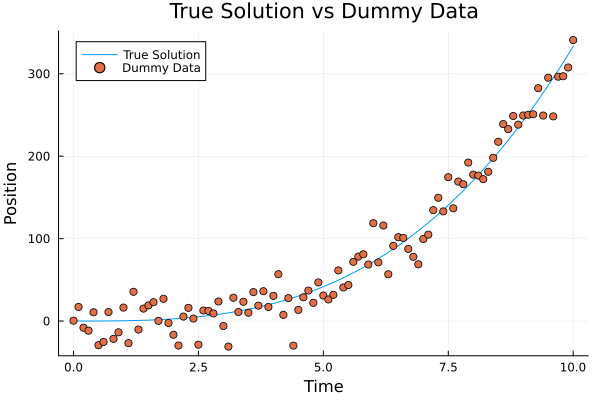

In [132]:
plot(sol.t,first.(sol.u),label="True Solution",xlabel="Time",ylabel="Position",title="True Solution vs Dummy Data")
plot!(sol.t,dummyData,label="Dummy Data",seriestype=:scatter)

In [133]:
@model function fitmodel(data, prob)
    # Prior
    σ ~ InverseGamma(2, 3)
    a ~ Normal(1.5,2.0)
    # Likelihood
    prob = remake(prob, p=[a])
    sol = solve(odeProblem, saveat=0.1)
    predicted = first.(sol.u)

    for i = 1:length(predicted)
        data[i] ~ Normal(predicted[i], σ)
    end
    return data
end

fitmodel (generic function with 4 methods)

In [139]:
@model function fitmodel(data, prob)
    # Prior
    σ ~ InverseGamma(1, 50)
    a ~ Normal(1.5,2.0)
    # Likelihood

    p = [a]
    prob = remake(prob,p=p)
    sol = solve(prob,Rosenbrock23(), saveat=0.1)
    predicted = first.(sol.u)
 
    for i = 1:length(predicted)
        data[i] ~ Normal(predicted[i], σ)
    end
    return nothing
end

fitmodel (generic function with 4 methods)

In [78]:
first.(sol.u)[1]

0.0

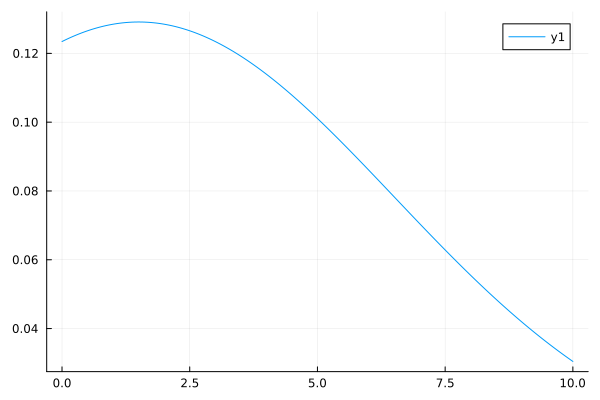

In [114]:
 
plot(0:0.01:10, pdf.(truncated(Normal(1.5,5.0),lower=0),0:0.01:10))

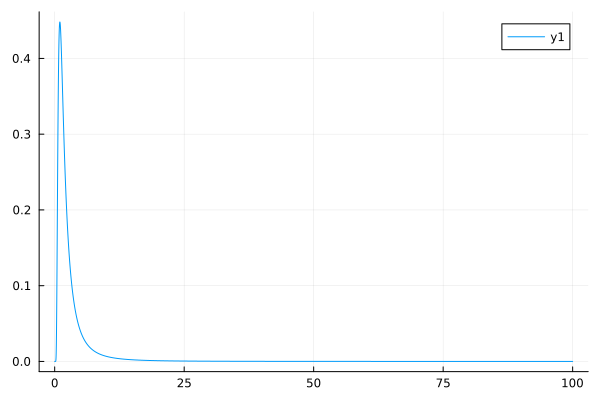

In [146]:
#plot the inverse gamma
plot(0:0.01:100, pdf.(InverseGamma(2,3),0:0.01:100))

In [140]:

model = fitmodel(dummyData, odeProblem)

DynamicPPL.Model{typeof(fitmodel), (:data, :prob), (), (), Tuple{Vector{Float64}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(fAcceleration), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}}, Tuple{}, DynamicPPL.DefaultContext}(fitmodel, (data = [0.41210144636122503, 17.115158845786233, -8.119337159567378, -11.683259057426183, 10.63063787712441, -29.310277390716678, -25.412402374151306, 10.898849010611192, -21.632908640795616, -13.698312492114148  …  250.27403054331364, 250.84822843247505, 282.4687709666439, 249.30934922175828, 295.2078001592816, 248.31117248838945, 296.46908534976717, 296.9811679822041, 307.62912778089395, 340.8802380668579], prob = ODEPr

In [141]:
# Sampling 
chain = sample(model, NUTS(1000,.85), MCMCSerial(), 1000, 3);

##

Chains MCMC chain (1000×14×3 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 12.59 seconds
Compute duration  = 12.55 seconds
parameters        = σ, a
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           σ   19.3722    1.4331     0.0262    0.0349   1745.7909    0.9996    ⋯
           a    1.9963    0.0292     0.0005    0.0006   1924.4179    1.0021    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        

In [142]:
chainDF = DataFrame(chain);

In [143]:
odeProblem = ODEProblem(fAcceleration,[0.0],(0.0,10.0),[mean(chainDF[!,:a])])
sol2 = solve(odeProblem, saveat=0.1);

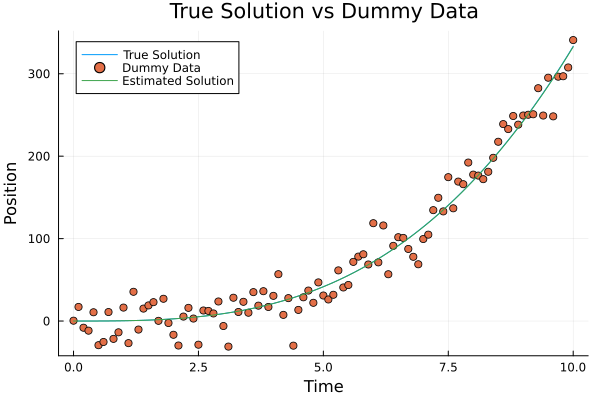

In [144]:
plot(sol.t,first.(sol.u),label="True Solution",xlabel="Time",ylabel="Position",title="True Solution vs Dummy Data")
plot!(sol.t,dummyData,label="Dummy Data",seriestype=:scatter)
plot!(sol2.t,first.(sol2.u),label="Estimated Solution")